In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import json as json

In [2]:
# we first uploaded the all 3 txt files in order to read them while handeling their diffrent formats and created 3 dataframes

department_df = pd.read_csv('/content/raw-department.txt', sep='-')
department_budget1_df = pd.read_json('/content/raw-department-budget.txt',lines=True )
department_budget2_df = pd.read_json('/content/raw-department-budget2.txt')
transactions_dates_df = pd.read_excel('/content/TransactionsDates1.xlsx')

In [3]:
# after we created the dataframes we checked the dataframes to see if it's working properly

department_df.head()
department_budget1_df.head()
department_budget2_df.head()

sub_dep_id    sub_dep_name  department_id  budget
0           1    IT purchases              3    2000
1           2  IT maintenance              3    1500
2           3        IT other              3    1000

In [4]:
# after we checked all of the dataframes we unionized the two json dataframes into one dataframe and checked to see if it's working

department_budget_df = pd.concat([department_budget1_df, department_budget2_df], axis=0)
department_budget_df.head()


sub_dep_id           sub_dep_name  department_id  budget
0           1               managers              1    3000
1           2              managers2              1    1500
2           1     sales support john              2    2000
3           2      sales support joe              2    1000
4           3  sales support johnson              2    2500

In [5]:
# now after we have created the two dataframes we want to join the dataframes into one and to sum the budgets of each department

merged_df = department_df.merge(department_budget_df, on = 'department_id', how = 'left')
merged_df.groupby(['department_id', 'department_name'])['budget'].sum()


department_id  department_name
1              General            4500
2              Sales Support      8000
3              IT                 4500
Name: budget, dtype: int64

In [6]:
# after we created the merged_df we've connected the new table to postgres 'chinook' database to the stg schema and checked if the connection was sucessful

import pandas as pd
from sqlalchemy import create_engine

db_user =  'postgres.nbaheajlimntaterdxvr'
db_password = 'lzuEEo8Bs7R4sumv'
db_host = 'aws-0-eu-central-1.pooler.supabase.com'
db_port = '6543'
db_name =  'chinook'

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

table_name = 'merged_df'
schema_name = 'stg'


merged_df.to_sql('merged_df', engine, schema = 'stg', if_exists='replace', index=False)

print("the table uploaded sucessfully")


the table uploaded sucessfully


In [11]:
import requests
import pandas as pd
import time


#Formats dates to correct string
dates = transactions_dates_df['Dates'].dt.strftime('%Y-%m-%d').tolist()
app_id = 'ff8f58c49cb74222a3d1c26cfb19aa17'

exchange_rates = []

for date in dates:
  url = f"https://openexchangerates.org/api/historical/{date}.json"
  params = {'app_id':app_id,
            'base':'USD',
            'symbols':'ILS'
           }
response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()
    ILS_rate = data['rates']['ILS']
    exchange_rates.append(ILS_rate)
else:
    print(f"Faild to fetch exchange rate for {date}. Status code: {response.status_code}")
    exchange_rates.append(None)

time.sleep(1)

transactions_dates_df['usd_to_ils'] = exchange_rates

output_path = '/content/TransactionsDates1.xlsx'
transactions_dates_df.to_excel(output_path, index=False)

print('Done! file saved at:', output_path)


Faild to fetch exchange rate for 2022-12-22. Status code: 429


KeyboardInterrupt: 

In [12]:
#importing dim_currency table to dbeaver database as a new table
import pandas as pd
from sqlalchemy import create_engine

db_user =  'postgres.nbaheajlimntaterdxvr'
db_password = 'lzuEEo8Bs7R4sumv'
db_host = 'aws-0-eu-central-1.pooler.supabase.com'
db_port = '6543'
db_name =  'chinook'

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

table_name = 'transactions_dates_df'
schema_name = 'stg'


transactions_dates_df.to_sql('transactions_dates_df', engine, schema = 'stg', if_exists='replace', index=False)

print("the table uploaded sucessfully")

the table uploaded sucessfully


In [13]:
import psycopg2
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine

# now we imported all the tables from sql database to google colab
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

query1 = 'select * from dwh.dim_currency dcurr'
query2 = 'select * from dwh.dim_customer dc'
query3 = 'select * from dwh.dim_employee de'
query4 = 'select * from dwh.dim_playlist dp'
query5 = 'select * from dwh.dim_track dt'
query6 = 'select * from dwh.fact_invoice fi'
query7 = 'select * from dwh.fact_invoiceline fil'

dim_currency = pd.read_sql_query(query1, engine)
dim_customer = pd.read_sql_query(query2, engine)
dim_employee = pd.read_sql_query(query3, engine)
dim_playlist = pd.read_sql_query(query4, engine)
dim_track = pd.read_sql_query(query5, engine)
fact_invoice = pd.read_sql_query(query6, engine)
fact_invoiceline = pd.read_sql_query(query7, engine)






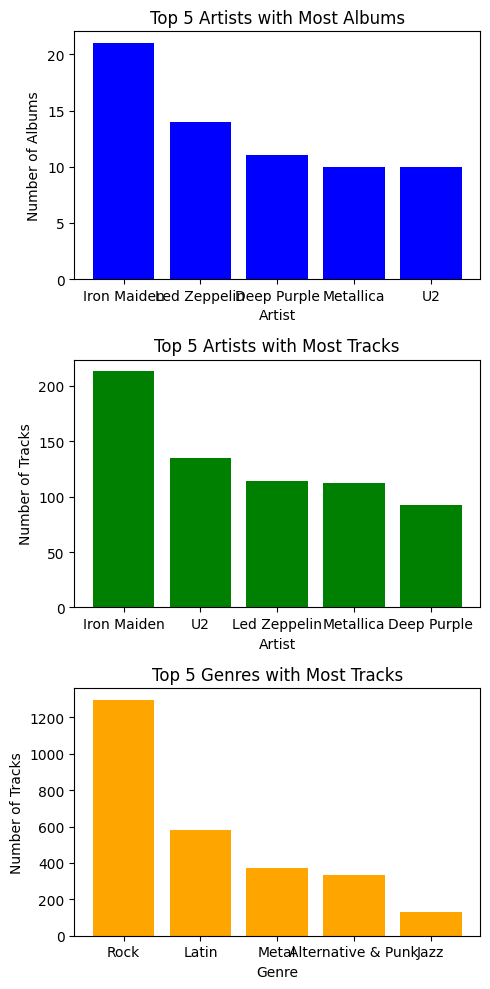

In [18]:
#first we analayse the top 5 artist with albums and tracks and the top 5 genres with most tracks

top_5_artists_with_albums = dim_track.groupby('artist_name')['albumid'].nunique().sort_values(ascending= False).head(5)
top_5_artists_with_tracks = dim_track.groupby('artist_name')['trackid'].nunique().sort_values(ascending= False).head(5)
top_5_genres_with_tracks = dim_track.groupby('genre_name')['trackid'].nunique().sort_values(ascending= False).head(5)



# we create 3 subplots in 1 figure
fig, axs = plt.subplots(3, 1, figsize=(5, 10))


# Graph of the top 5 artists with albums
axs[0].bar(top_5_artists_with_albums.index, top_5_artists_with_albums.values, color='blue')
axs[0].set_title('Top 5 Artists with Most Albums')
axs[0].set_ylabel('Number of Albums')
axs[0].set_xlabel('Artist')


#Graph of the top 5 artist with tracks
axs[1].bar(top_5_artists_with_tracks.index, top_5_artists_with_tracks.values, color='green')
axs[1].set_title('Top 5 Artists with Most Tracks')
axs[1].set_ylabel('Number of Tracks')
axs[1].set_xlabel('Artist')


#Graph of the top 5 genres with tracks
axs[2].bar(top_5_genres_with_tracks.index, top_5_genres_with_tracks.values, color='orange')
axs[2].set_title('Top 5 Genres with Most Tracks')
axs[2].set_ylabel('Number of Tracks')
axs[2].set_xlabel('Genre')

# show the graphs we made
plt.tight_layout()
plt.show()

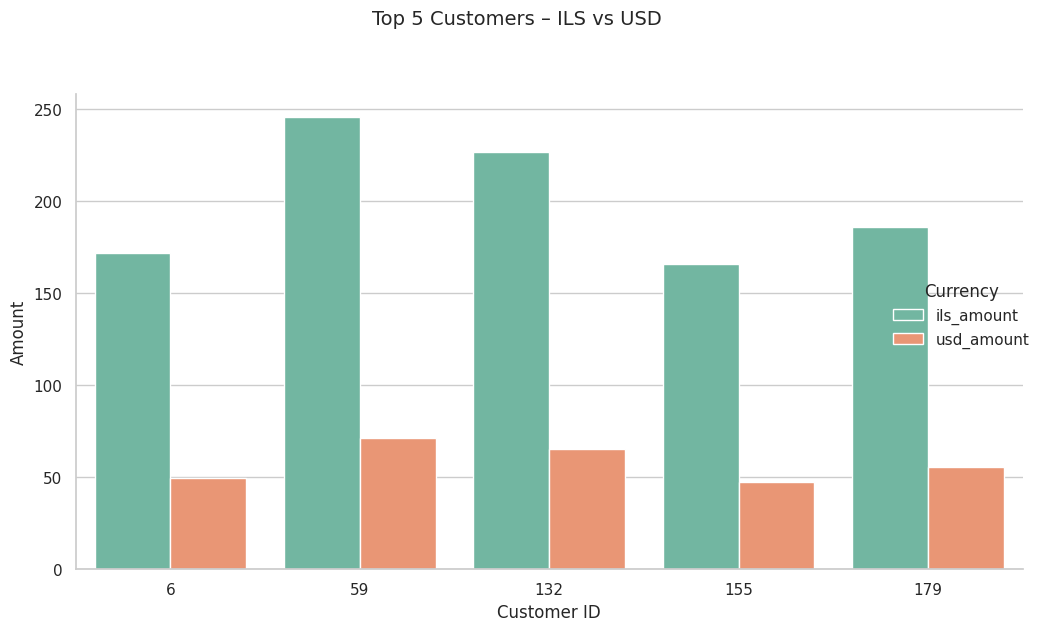

In [40]:
# שינוי שם העמודה לצורך התאמה למיזוג
dim_currency.rename(columns={'Dates': 'invoicedate'}, inplace=True)

# מיזוג לפי תאריך
dim_currency_merge = dim_currency.merge(fact_invoice, on='invoicedate', how='left')

# חישוב סכומים
dim_currency_merge['ils_amount'] = dim_currency_merge['total'] * dim_currency_merge['usd_to_ils']
dim_currency_merge['usd_amount'] = dim_currency_merge['total']

# מיזוג עם לקוחות
customer_ils = dim_currency_merge.merge(dim_customer, on='customerid', how='left')

# קיבוץ וחישוב סה"כ
top_5_customers = (
    customer_ils.groupby('customerid')[['ils_amount','usd_amount']]
    .sum()
    .sort_values(by='ils_amount', ascending=False)
    .reset_index()
    .head(5)
)

# המסת הטבלה לגרף עם hue
top_5_melted = pd.melt(top_5_customers,
                       id_vars='customerid',
                       value_vars=['ils_amount', 'usd_amount'],
                       var_name='Currency',
                       value_name='Amount')

# יצירת catplot
sns.set(style="whitegrid")
g = sns.catplot(
    data=top_5_melted,
    kind='bar',
    x='customerid',
    y='Amount',
    hue='Currency',
    palette='Set2',
    height=6,
    aspect=1.5
)

# עיצוב
g.set_axis_labels("Customer ID", "Amount")
g.fig.suptitle("Top 5 Customers – ILS vs USD", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

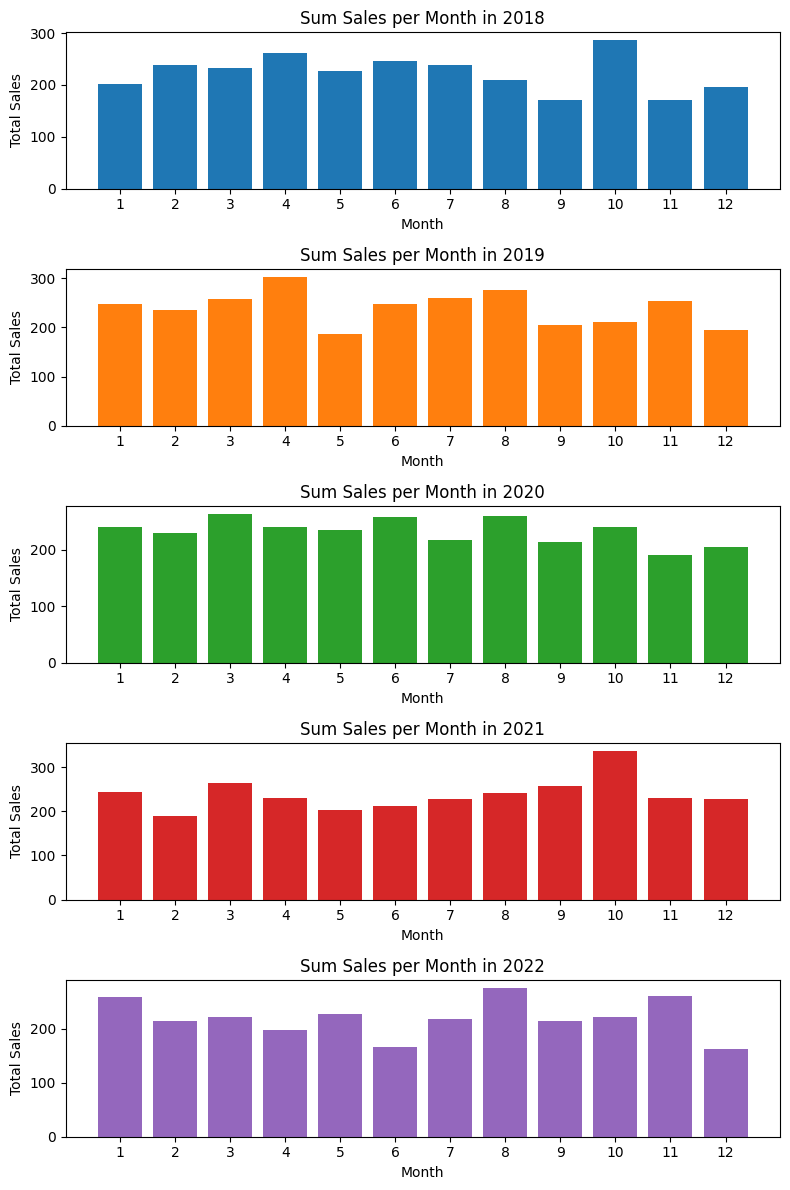

In [38]:

# קיבוץ מראש, כמו שעשית
fact_invoice['year'] = fact_invoice['invoicedate'].dt.year
fact_invoice['month'] = fact_invoice['invoicedate'].dt.month
fact_invoice_group = fact_invoice.groupby(['year', 'month'])['total'].sum().reset_index()
fact_invoice_group = fact_invoice_group.sort_values(by=['year', 'month'])

# יצירת רשימת שנים קיימות (כדי לא לקודד ידנית)
years = fact_invoice_group['year'].unique()

# ציור תתי גרפים
fig, axs = plt.subplots(len(years), 1, figsize=(8, 12))

for i, year in enumerate(years):
    yearly_data = fact_invoice_group[fact_invoice_group['year'] == year]
    axs[i].bar(yearly_data['month'], yearly_data['total'], color='C'+str(i))
    axs[i].set_title(f'Sum Sales per Month in {year}')
    axs[i].set_ylabel('Total Sales')
    axs[i].set_xlabel('Month')
    axs[i].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

<ipython-input-137-6afcc707a430>:12: MatplotlibDeprecationWarning: You have mixed positional and keyword arguments, some input may be discarded.  This is deprecated since 3.9 and will become an error in 3.11.
  plt.legend(legend_labels, title='Track Length', labels = legend_labels)


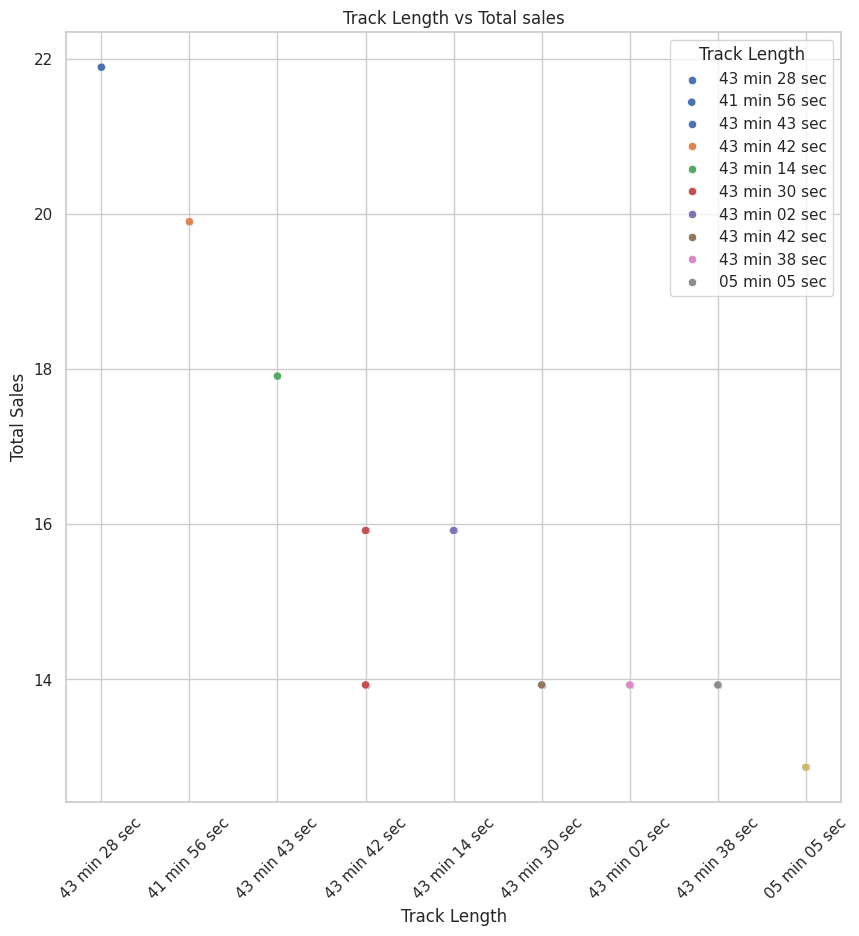

In [137]:
track_sales = dim_track.merge(fact_invoiceline, on='trackid', how='left')
track_sales = track_sales.groupby(['trackid','length'])['line_total'].sum().reset_index()
track_sales = track_sales.sort_values(by='line_total', ascending=False).head(10)
track_sales

plt.figure(figsize=(10, 10))
sns.scatterplot(data=track_sales, x='length', y='line_total')
specific_length = track_sales[(track_sales['length'] == '43 min 28 sec') | (track_sales['length'] == '41 min 56 sec') | (track_sales['length'] == '43 min 43 sec') | (track_sales['length'] == '43 min 42 sec') | (track_sales['length'] == '43 min 14 sec') | (track_sales['length'] == '43 min 30 sec') | (track_sales['length'] == '43 min 02 sec') | (track_sales['length'] == '43 min 42 sec') | (track_sales['length'] == '43 min 38 sec') | (track_sales['length'] == '05 min 05 sec') ]
sns.scatterplot(data=specific_length, x='length', y='line_total', color='red', hue = 'length')
hue_order = ['43 min 28 sec', '41 min 56 sec', '43 min 43 sec', '43 min 42 sec', '43 min 14 sec', '43 min 30 sec', '43 min 02 sec', '43 min 42 sec', '43 min 38 sec', '05 min 05 sec']
legend_labels = ['43 min 28 sec', '41 min 56 sec', '43 min 43 sec', '43 min 42 sec', '43 min 14 sec', '43 min 30 sec', '43 min 02 sec', '43 min 42 sec', '43 min 38 sec', '05 min 05 sec']
plt.legend(legend_labels, title='Track Length', labels = legend_labels)
plt.title('Track Length vs Total sales')
plt.xlabel('Track Length')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()


#after we created the graph we took the 10 most sold out track sales according their lenth to if there is a corraltion between the track's length vs their total_sales, we can see that there is corraltion between the two.

In [136]:
def recommend_tracks_for_customer(customerid):
    # בדיקה האם הלקוח קיים בטבלת fact_invoice
    if customerid not in fact_invoice['customerid'].unique():
        print(f"Customer ID {customerid} not found in fact_invoice.")
        return pd.DataFrame()

    # מיזוג בין חשבוניות ולקוחות
    customer_purchases = fact_invoice[fact_invoice['customerid'] == customerid]
    if customer_purchases.empty:
        print(f"No invoices found for customer {customerid}.")
        return pd.DataFrame()

    # מיזוג עם שורות החשבוניות
    customer_purchases = customer_purchases.merge(fact_invoiceline, on='invoiceid', how='left')
    if customer_purchases.empty:
        print(f"No invoice lines found for customer {customerid}.")
        return pd.DataFrame()

    # מיזוג עם טבלת השירים
    customer_tracks = customer_purchases.merge(dim_track, on='trackid', how='left')
    if customer_tracks.empty:
        print(f"No track details found for customer {customerid}.")
        return pd.DataFrame()

    # חישוב הז'אנרים המועדפים (Top 2)
    favorite_genres = (
        customer_tracks
        .groupby('genre_name')['quantity']
        .sum()
        .sort_values(ascending=False)
        .head(2)
        .index
        .tolist()
    )

    if not favorite_genres:
        print(f"No favorite genres found for customer {customerid}.")
        return pd.DataFrame()

    print(f"Favorite genres for customer {customerid}: {favorite_genres}")

    # רשימת שירים שהלקוח כבר רכש
    tracks_already_purchased = customer_tracks['trackid'].unique()

    recommendations = []

    for genre in favorite_genres:
        # חיפוש שירים פופולריים בז'אנר שטרם נרכשו
        genre_tracks = dim_track[dim_track['genre_name'] == genre]

        genre_purchases = (
            fact_invoiceline
            .merge(genre_tracks, on='trackid')
            .query("trackid not in @tracks_already_purchased")
        )

        if genre_purchases.empty:
            print(f"No new tracks to recommend in genre '{genre}' for customer {customerid}.")
            continue

        top_tracks = (
            genre_purchases
            .groupby(['trackid', 'genre_name'])['quantity']
            .sum()
            .reset_index()
            .sort_values(by='quantity', ascending=False)
            .head(3)
        )

        # מיזוג כדי להביא את שם השיר
        top_tracks = top_tracks.merge(dim_track[['trackid', 'track_name']], on='trackid', how='left')
        recommendations.append(top_tracks)

    if not recommendations:
        print(f"No recommendations available for customer {customerid}.")
        return pd.DataFrame()

    final_recommendations = pd.concat(recommendations).reset_index(drop=True)
    final_recommendations['customerid'] = customerid

    return final_recommendations[['customerid', 'trackid', 'track_name', 'genre_name', 'quantity']]

# דוגמה להרצה:
recommended_tracks = recommend_tracks_for_customer(1)
recommended_tracks

Favorite genres for customer 1: ['Rock', 'Latin']


customerid  trackid                                        track_name  \
0           1     2672                                    Paint It Black   
1           1     2968                           City Of Blinding Lights   
2           1     2153  Elderly Woman Behind The Counter In A Small Town   
3           1      380                                  Samba da Bençaco   
4           1      594                           Agora Que O Dia Acordou   
5           1      663                        Chão de Giz (Elba Ramalho)   

  genre_name  quantity  
0       Rock        12  
1       Rock        11  
2       Rock        11  
3      Latin        11  
4      Latin        10  
5      Latin        10

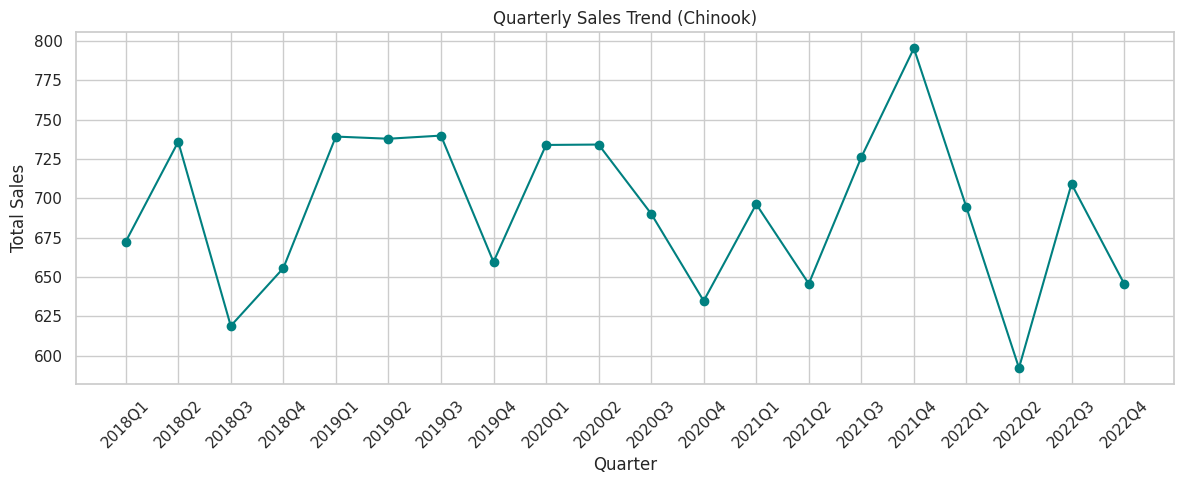

In [140]:
# Extra python analysis checks the Monthly sales trend benchmark in order to:
# Identifying Seasonality or Consistent Patterns
# Detecting Low-Performance Months
# Measuring the Impact of Campaigns or Changes
# Future Forecasting (Time Series Analysis)
# Period-to-Period Comparison

# הנחה: יש עמודת תאריך בשם 'invoicedate' ב-fact_invoice
fact_invoice['invoicedate'] = pd.to_datetime(fact_invoice['invoicedate'])

# הוספת עמודות של שנה ורבעון
fact_invoice['year'] = fact_invoice['invoicedate'].dt.year
fact_invoice['quarter'] = fact_invoice['invoicedate'].dt.to_period('Q').astype(str)  # למשל: 2024Q1

# סכום מכירות לפי רבעון
quarterly_sales = (
    fact_invoice
    .groupby('quarter')['total']
    .sum()
    .reset_index()
    .sort_values('quarter')
)

# ציור גרף קו של מכירות רבעוניות
plt.figure(figsize=(12,5))
plt.plot(quarterly_sales['quarter'], quarterly_sales['total'], marker='o', color='teal')
plt.title('Quarterly Sales Trend (Chinook)')
plt.xlabel('Quarter')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()